# Hide your messy video background using neural nets, Part 1
> "Use fastai to separate a person in a video from the background. Start from scratch with creating your own dataset."

- toc: true
- branch: master
- badges: true
- comments: false
- categories: [fastai, privacy, getting started]
- image: images/articles/2021-backgroundblur-1/thumbnail-yellow.png
- hide: false

&nbsp;
<video width="640" height="360" controls autoplay loop muted playsinline>
  <source src="/images/articles/2021-backgroundblur-2/smooth.mp4" type="video/mp4">
  <source src="/images/articles/2021-backgroundblur-2/smooth.webm" type="video/webm">
Your browser does not support the video tag.
</video> 

This tutorial teaches you to train a neural network to distinguish the person in a webcam shot from the background. Foreground/background detection can be useful in many applications. Examples are adding bokeh to photos (portrait mode of smartphones) or automatic removal of the background in photo editing.

I did this as a little project inspired by OpenMined's [privacy course](https://deeplearning.berlin/online%20courses/privacy/the%20private%20ai%20series/openmined/2021/01/08/Our-Privacy-Opportunity-Part-1.html). Blurring the background during a Zoom call is an example of [output privacy](https://deeplearning.berlin/online%20courses/privacy/the%20private%20ai%20series/openmined/2021/01/19/Our-Privacy-Opportunity-Part-3.html#Output-Privacy). It refers to the concept that you often want to share some information (that you are present in a video call, how you look, ...) but not additional information (your location, the stuff in your living room, the medication on the shelf behind you).

We begin with collecting our own data, annotating images, and end up with a useful model. In this blog post, I'll guide you through the process. We'll be using a webcam and SuperAnnotate to create our dataset. Then, we'll use fastai to train a neural network (specifically, a U-Net) to recognize a person in a frame. I assume that you know the basics of fastai. The training process is straightforward however, so it's a good example of how the library works even if you never used it.

## Creating Your Own Dataset

To create your own dataset, just use your webcam to snap a few photos of you. I took around **40 photos** in slightly different poses and hope that's enough!

The next step is annotation. I recently discovered [SuperAnnotate](https://superannotate.com/) which promises to be the "fastest annotation platform". Let's give it a try.

The application runs in the browser and comes with a rather hefty price tag, starting from 62$ per month. They offer a 14-day trial however, and also a free desktop software. The desktop version is missing some features but can be used without any limitations.

1\. Create a `Pixel` Project:

![Create pixel project](../images/articles/2021-backgroundblur-1/pixelproject.png)

2\. Add a single class "Person":

![Add a class](../images/articles/2021-backgroundblur-1/class.png)

3\. You can leave "Contributers" empty and click `Create`.

4\. Now you can `Upload` your photos.

5\. Select the outlines of your body with the Polygon tool (key binding `Z`)

6\. Hit `Space` to create an instance and choose the Person class 
<img src="../images/articles/2021-backgroundblur-1/person.png" width="576" />

7\. Click `Complete` in the lower right.

8\. Repeat for all images.

9\. Return to the home page and select `Download`. Click `Prepare for Download`, select `Completed` images and click `Prepare`. Download the resulting zip file.

One feature I found extremely helpful was the auto-segmentation feature (you can see it in action with the green lines in the screenshot). To activate it, select all images on the home page and select the `Smart Segmentation` button to the right:

![Use smart select](../images/articles/2021-backgroundblur-1/home.png)

The detection of connected areas works very well and makes exact annotations easy. Some manual corrections are quickly done using the brush tool. This feature is unfortunately only available in the browser version.

![SuperAnnotate Screenshot](../images/articles/2021-backgroundblur-1/superannotate.png)

## Preparing Data

I ran this notebook on [Paperspace Gradient](https://gradient.paperspace.com/), a cloud platform that offers a ready-to-use fastai environment and free GPU options. You can also run it on Google Colab, which is entirely free.

In [2]:
#hide
!pip install fastai==2.2.5 -q

In [ ]:
from fastai.vision.all import *
from zipfile import ZipFile

In [4]:
path = Path('')

I uploaded the zip files with the training images and the annotations to Paperspace

In [7]:
with ZipFile('training.zip') as file:
    file.extractall()

In [8]:
with ZipFile('SuperAnnotate.zip') as file:
    file.extractall('masks')

Collect all training images using the fastai function `get_image_files` and look at filename format:

In [ ]:
images = get_image_files(path/'training')
images[0]

How many images do we have?

In [10]:
len(images)

41

Get the annotation files, look at filename format:

In [11]:
masks = get_image_files(path/'masks')
masks[0]

Path('masks/WIN_20210208_09_13_12_Pro.jpg___save.png')

In [12]:
len(masks)

41

We have 41 training images as well as 41 matching annotations. The annotated files have the same name as the training images with the extension of `___save.png`

A function to get the training image for every mask:

In [13]:
def get_y(fn):
    return path/'masks'/(fn.name+'___save.png')

Let's look at the images.

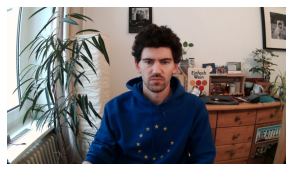

In [21]:
img = PILImage.create(images[2])
img.show();

Looks as expected. What about the annotations?

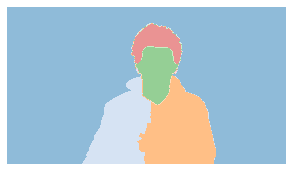

In [22]:
annotation = PILMask.create(get_y(images[2]))
annotation.show();

This is not the kind of mask we wanted. We just want to classify whether a pixel is `person` or `background`. The more fine-grained segmentation here is an artifact of SuperAnnotate's auto-segmentation feature. Which is extremely helpful to quickly annotate images, but it creates more categories than we want:

In [25]:
np.unique(annotation)

array([ 0,  2,  3,  5,  7, 19, 21], dtype=uint8)

These are too many categories, we need to convert this mask into a simple `0` or `1` mask.

In [26]:
def create_mask(fn):
    maskfile = get_y(fn)
    mask = np.array(PILMask.create(maskfile))
    # Turn every number larger than 0 into a 1
    mask[mask > 0] = 1
    return PILMask.create(mask)

In [28]:
mask = create_mask(fnames[0])
np.unique(mask)

array([0, 1], dtype=uint8)

Now the masks are looking good.

## Loading the Data

We use fastai's `DataBlock` API to quickly collect our data. For details, please check [chapter 2](https://github.com/fastai/fastbook/blob/master/02_production.ipynb) of the fabulous book from Jeremy Howard & Sylvain Gugger.
- Use ImageBlock and MaskBlock to define the task
- Collect all training images with `get_image_files`
- Set aside 20% of images as the validation set
- Define the masks with our `create_mask` function
- Resize frames to a managable size of 640x360
- Normalize according to the Imagenet stats

In [17]:
codes = ['Background', 'Person']
binary = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(0.2),
                   get_y=create_mask,
                   item_tfms=Resize((360, 640)),
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)])

Create `dataloaders` with all files in the `training` folder. The batch size is only 2 in order to avoid running out of GPU RAM, since our model will be quite heavy.

In [18]:
dls = binary.dataloaders(path/'training', bs=2)

Look at some example pictures. We set `vmin` and `vmax` to match our 2 classes.

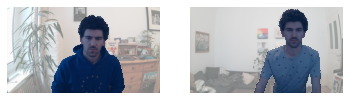

In [19]:
dls.show_batch(cmap='Blues', vmin=0, vmax=1)

Looks good! Let's train.

## Training a Model

We treat this as a semantic segmentation problem, where for every pixel the neural net determines whether it belongs to a person or to the background. fastai has a convenient function to create a model with the U-Net architecture, using a pretrained backbone. For details, please check out [chapter 15](https://github.com/fastai/fastbook/blob/master/15_arch_details.ipynb) of the fastai book.

In [ ]:
learn = unet_learner(dls, resnet18)

In [21]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,time
0,0.707564,0.483769,00:11


epoch,train_loss,valid_loss,time
0,0.206661,0.067774,00:07
1,0.126953,0.058315,00:07
2,0.089094,0.027516,00:07
3,0.065168,0.021403,00:07
4,0.049638,0.020775,00:07


Our validation loss decreased nicely after only a few seconds of training. Let's see if our tiny dataset is actually sufficient!

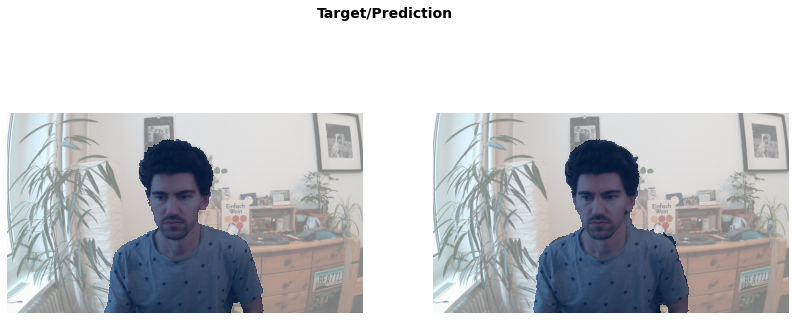

In [27]:
learn.show_results(cmap='Blues', vmin=0, vmax=1, figsize=(14,6))

Looks pretty good! Let's export our model.

In [30]:
learn.export()

Now it's time to hide the mess in the background! In [Part 2](https://deeplearning.berlin/fastai/privacy/opencv/2021/02/10/Background-Blur-Part-2.html) we'll use our trained model to blur the background of a video.